# Data

> Data classes and functions

In [ ]:
#| default_exp data

In [ ]:
#| hide
from nbdev.showdoc import *

## Data types

The module introduces specialized classes to represent various bioimaging data structures, facilitating seamless integration with machine learning workflows.

In [ ]:
#| export
import os
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm 
import random
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from sklearn.model_selection import train_test_split
from torch import stack as torch_stack

from bioMONAI.core import MetaTensor, torchTensor, BypassNewMeta, DisplayedTransform, torchsqueeze, Path, List, L, torchmax, randint, typedispatch
from bioMONAI.io import image_reader
from bioMONAI.visualize import show_images_grid, show_multichannel

from fastai.data.all import DataLoaders, delegates, RegexLabeller, is_listy, ColReader, ColSplitter
from fastai.vision.all import DataBlock, CategoryBlock, MultiCategoryBlock, RegressionBlock, TfmdDL, get_image_files, TransformBlock, get_grid, merge, show_image, RandomSplitter, GrandparentSplitter, partial, parent_label

/home/biagio/miniconda3/envs/bm/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/biagio/miniconda3/envs/bm/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might

In [ ]:
#| export

class MetaResolver(type(torchTensor), metaclass=BypassNewMeta):
    """
    The `MetaResolver` class addresses metaclass conflicts, ensuring compatibility across different data structures. This is particularly useful when integrating with libraries that have specific metaclass requirements.
    """
    pass
    

In [ ]:
#| export
class BioImageBase(MetaTensor, metaclass=MetaResolver):
    """
    Serving as the foundational class for bioimaging data, `BioImageBase` provides core functionalities for image handling. It ensures that instances of specified types are appropriately cast to this class, maintaining consistency in data representation.
    
    Metaclass casts `x` to this class if it is of type `cls._bypass_type`.
    """
    
    _bypass_type = torchTensor  # The type that bypasses image loading
    _show_args = {'cmap': 'gray'}  # Default arguments for image display
    resample, reorder = None, False  # Default resample and reorder settings
    affine_matrix = None  # Default affine matrix for image transformation

    @classmethod
    def create(cls, fn: (Path, str, List, torchTensor), **kwargs) -> torchTensor: 
        """
        Opens an image and casts it to BioImageBase object.
        If `fn` is a torchTensor, it's cast to BioImageBase object.

        Args:
            fn : (Path, str, torchTensor)
                Image path or a 4D torchTensor.
            kwargs : dict
                Additional parameters for the medical image reader.

        Returns:
            torchTensor : A 4D tensor as a BioImageBase object.
        """
        if isinstance(fn, torchTensor):
            return cls(fn)

        return image_reader(fn, dtype=cls, resample=cls.resample, reorder=cls.reorder)

    @classmethod
    def item_preprocessing(cls, resample: (List, int, tuple), reorder: bool):
        """
        Changes the values for the class variables `resample` and `reorder`.

        Args:
            resample : (List, int, tuple)
                A list with voxel spacing.
            reorder : bool
                Whether to reorder the data to be closest to canonical (RAS+) orientation.
        """
        cls.resample = resample
        cls.reorder = reorder

    def show(self, ctx=None, figsize: int = None, ncols: int = 10, title=None, **kwargs):
        """
        Plots 2D slices of a 3D image alongside a prior specified axis.

        Args:
            ctx : Context to use for the display. Defaults to None.
            figsize: Size of the figure. Defaults to None.
            ncols: Number of columns in the grid. Defaults to 10.
            **kwargs : Additional keyword arguments passed to plt.imshow.

        Returns:
            Shown image.
        """
        return show_images_grid(self, ctx=ctx, ncols=ncols, title=[title], **merge(self._show_args, kwargs))
    
    def as_tensor(self) -> torchTensor:
        """
        Return the `MetaTensor` as a `torchTensor`.
        It is OS dependent as to whether this will be a deep copy or not.
        """
        return self.as_subclass(torchTensor)

    def __repr__(self) -> str:
        """Returns the string representation of the ImageBase instance."""
        return f"BioImageBase{self.as_tensor().__repr__()[6:]}"

In [ ]:
#| export

class BioImage(BioImageBase):
    """
    A subclass of `BioImageBase`, the `BioImage` class is tailored for handling both 2D and 3D image objects. It offers methods to load images from various formats and provides access to image properties such as shape and dimensions.
    """
    _show_args = {'cmap':'gray'}
    
    @classmethod
    def create(cls, fn: (Path, str, L, list, torchTensor), **kwargs) -> torchTensor: 
        """
        Opens an image and casts it to BioImageBase object.
        If `fn` is a torchTensor, it's cast to BioImageBase object.

        Args:
            fn : (Path, str, torchTensor)
                Image path or a 4D torchTensor.
            kwargs : dict
                Additional parameters for the medical image reader.

        Returns:
            torchTensor : A 2D or 3D tensor as a BioImage object.
        """
        if isinstance(fn, torchTensor):
            return cls(fn)

        return torchsqueeze(image_reader(fn, dtype=cls, resample=cls.resample, reorder=cls.reorder), 1)
    
    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))
    
    def __repr__(self) -> str:
        """Returns the string representation of the ImageBase instance."""
    #     return f'{self.__class__.__name__} shape={"x".join([str(d) for d in self.shape])}'
        return f"BioImage{self.as_tensor().__repr__()[6:]}"

In [ ]:
a = BioImage.create('data_examples/example_tiff.tiff')
print(a.shape)


torch.Size([1, 96, 512, 512])


In [ ]:
#| export
class BioImageStack(BioImageBase):
    """
    Designed for 3D image data, `BioImageStack` extends `BioImageBase` to manage volumetric images effectively. 
    It includes functionalities for slicing, visualization, and manipulation of 3D data.
    """
    
    def __repr__(self) -> str:
        """Returns the string representation of the ImageBase instance."""
        return f"BioImageStack{self.as_tensor().__repr__()[6:]}"

In [ ]:
a = BioImageStack.create('data_examples/example_tiff.tiff')
print(a.shape)

torch.Size([1, 96, 512, 512])


In [ ]:
#| export

class BioImageProject(BioImageBase):
    """
    The `BioImageProject` class represents a 3D image stack as a 2D image using maximum intensity projection. This is particularly useful for visualizing volumetric data in a 2D format, aiding in quick assessments and presentations.
    """
    _show_args = {'cmap':'gray'}
    
    @classmethod
    def create(cls, fn: (Path, str, L, list, torchTensor), **kwargs) -> torchTensor: 
        """
        Opens an image and casts it to BioImageBase object.
        If `fn` is a torchTensor, it's cast to BioImageBase object.

        Args:
            fn : (Path, str, torchTensor)
                Image path or a 4D torchTensor.
            kwargs : dict
                Additional parameters for the medical image reader.

        Returns:
            torchTensor : A 3D tensor as a BioImage object.
        """
        if isinstance(fn, torchTensor):
            return cls(fn)

        img = image_reader(fn, dtype=cls, resample=cls.resample, reorder=cls.reorder)
        return torchmax(img, dim=1)[0]  # Taking the maximum intensity projection along axis 1
    
    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))
    
    def __repr__(self) -> str:
        """Returns the string representation of the ImageBase instance."""
        return f"BioImageProject{self.as_tensor().__repr__()[6:]}"

In [ ]:
a = BioImageProject.create('data_examples/example_tiff.tiff')
a.shape

torch.Size([1, 512, 512])

In [ ]:
#| export

class BioImageMulti(BioImageBase):
    """
    For multi-channel 2D images, `BioImageMulti` extends `BioImageBase` to handle data with multiple channels, such as different fluorescence markers in microscopy images. 
    """
    
    @classmethod
    def create(cls, fn: (Path, str, L, list, torchTensor), **kwargs) -> torchTensor: 
        """
        Opens an image and casts it to BioImageBase object.
        If `fn` is a torchTensor, it's cast to BioImageBase object.

        Args:
            fn : (Path, str, torchTensor)
                Image path or a 4D torchTensor.
            kwargs : dict
                Additional parameters for the medical image reader.

        Returns:
            torchTensor : A 3D tensor as a BioImage object.
        """
        if isinstance(fn, torchTensor):
            return cls(fn)

        return torchsqueeze(image_reader(fn, dtype=cls, resample=cls.resample, reorder=cls.reorder))
    
    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_multichannel(self, ctx=ctx, **merge(self._show_args, kwargs))
    
    def __repr__(self) -> str:
        """Returns the string representation of the ImageBase instance."""
        return f"BioImageMulti{self.as_tensor().__repr__()[6:]}"
        

In [ ]:
# Load a 3D image stack as a multichannel image
a = BioImageMulti.create('data_examples/example_tiff.tiff')
# Differently from BioImageStack, here the third dimension is encoded as channels.
print(a.shape)

torch.Size([96, 512, 512])


In [ ]:
#| hide

# show function should be implemented
class BioImage4D(BioImageBase):
    """Subclass of BioImageBase that represents a (multi-channel) 3D image object."""
    
    @classmethod
    def create(cls, fn: (Path, str, L, list, torchTensor), **kwargs) -> torchTensor: 
        """
        Opens an image and casts it to BioImageBase object.
        If `fn` is a torchTensor, it's cast to BioImageBase object.

        Args:
            fn : (Path, str, torchTensor)
                Image path or a 4D torchTensor.
            kwargs : dict
                Additional parameters for the medical image reader.

        Returns:
            torchTensor : A 3D tensor as a BioImage object.
        """
        if isinstance(fn, torchTensor):
            return cls(fn)

        return torchsqueeze(image_reader(fn, dtype=cls, resample=cls.resample, reorder=cls.reorder), 1)
    
    def __repr__(self) -> str:
        """Returns the string representation of the ImageBase instance."""
        return f"BioImage4D{self.as_tensor().__repr__()[6:]}"

In [ ]:
#| hide
# from torch import randn as torchrandn
# from bioMONAI.visualize import slice_explorer

# b = BioImage4D.create(torchrandn(3, 10, 4, 5))
# print(b.shape)
# slice_explorer(b)

## Data conversion

To facilitate seamless integration between tensors and bioimaging data structures, the module provides conversion utilities.


In [ ]:
#| export

class Tensor2BioImage(DisplayedTransform):
    """
    The `Tensor2BioImage` transform converts tensors into `BioImageBase` instances, enabling the application of bioimaging-specific methods to tensor data. 
    This is essential for integrating deep learning models with bioimaging workflows.
    """
    def __init__(self, cls:BioImageBase=BioImageStack):
        self.cls = cls

    def encodes(self, o):
        if isinstance(o, MetaTensor):
            # return self.cls(o.clone(), affine=o.affine, meta=o.meta)
            return self.cls(o.clone(), meta=o.meta)
        
        if isinstance(o, torchTensor):
            return self.cls(o)

## Data Blocks and Dataloader

The module offers classes to construct data blocks and data loaders, streamlining the preparation of datasets for machine learning models.


In [ ]:
#| export
def BioImageBlock(cls:BioImageBase=BioImage):
    "A `TransformBlock` tailored for bioimaging data, `BioImageBlock` facilitates the creation of data processing pipelines, including transformations and augmentations specific to bioimaging."
    return TransformBlock(type_tfms=[cls.create, Tensor2BioImage(cls)]) # IntToFloatTensor

In [ ]:
#| export
class BioDataBlock(DataBlock):
    """ 
    The `BioDataBlock` class serves as a generic container to build `Datasets` and `DataLoaders` efficiently. It integrates item and batch transformations, getters, and splitters, simplifying the setup of data pipelines for training and validation.
    """
    def __init__(self, 
            blocks:list=(BioImageBlock(cls=BioImage), BioImageBlock(cls=BioImage)), # One or more `TransformBlock`s
            dl_type:TfmdDL=None,                                                    # Task specific `TfmdDL`, defaults to `block`'s dl_type or`TfmdDL`
            get_items=get_image_files,
            get_y=None,
            get_x=None,
            getters:list=None,                                                      # Getter functions applied to results of `get_items`
            n_inp:int=None,                                                         # Number of inputs
            item_tfms:list=None,                                                    # `ItemTransform`s, applied on an item 
            batch_tfms:list=None,                                                   # `Transform`s or `RandTransform`s, applied by batch
            **kwargs, 
        ):
        super().__init__(
            blocks=blocks, 
            dl_type=dl_type, 
            get_items=get_items,
            get_y=get_y,
            get_x=get_x,
            getters=getters, 
            n_inp=n_inp, 
            item_tfms=item_tfms, 
            batch_tfms=batch_tfms,
            **kwargs,
            )
        

In [ ]:
#| export
class BioDataLoaders(DataLoaders):
    """
    Basic wrapper around several `DataLoader`s with factory methods for biomedical imaging problems.
    Managing multiple `DataLoader` instances, `BioDataLoaders` handles data loading for different phases of model training, such as training, validation, and testing. It ensures efficient data handling and supports various batch processing strategies.
    """
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_source(cls, 
                    data_source, # The source of the data to be loaded by the dataloader. This can be any type that is compatible with the dataloading method specified in kwargs (e.g., paths, datasets).
                    show_summary:bool=False, # If True, print a summary of the BioDataBlock after creation.
                    **kwargs, # Additional keyword arguments to configure the DataLoader and BioDataBlock. Supported keys include: 'blocks', 'dl_type', 'get_items', 'get_y', 'get_x', 'getters', 'n_inp', 'item_tfms', 'batch_tfms'.
                    ):
        """
        Create and return a DataLoader from a BioDataBlock using provided keyword arguments.
        
        Returns a  DataLoader: A PyTorch DataLoader object populated with the data from the BioDataBlock.
                        If show_summary is True, it also prints a summary of the datablock after creation.
        
        """
        # Define the keys for BioDataBlock operations
        datablock_ops_keys = ['blocks','dl_type','get_items','get_y','get_x','getters','n_inp','item_tfms','batch_tfms','splitter']
        
        # Filter and assign kwargs to datablock_ops dictionary for BioDataBlock initialization
        datablock_ops = {key: value for key, value in kwargs.items() if key in datablock_ops_keys}
        
        # Filter and assign remaining kwargs to dataloader_ops dictionary for DataLoader creation
        dataloader_ops = {key: value for key, value in kwargs.items() if key not in datablock_ops_keys}
        
        # Initialize BioDataBlock with specified operations
        datablock = BioDataBlock(**datablock_ops)
    
        # Create and return the DataLoader from the initialized BioDataBlock
        dataloder = datablock.dataloaders(data_source, **dataloader_ops)
        
        # Optionally print a summary of the BioDataBlock if show_summary is True
        if show_summary:
            bs = dataloader_ops['bs'] if dataloader_ops['bs'] is not None else 1
            print(datablock.summary(data_source, bs=bs))
        
        return dataloder

    @classmethod
    @delegates(from_source)
    def from_folder(cls, path, get_target_fn, train='train', valid='valid', valid_pct=None, seed=None, item_tfms=None,
                    batch_tfms=None, img_cls=BioImage, target_img_cls=BioImage, **kwargs):
        "Create from dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        get_items = get_image_files if valid_pct else partial(get_image_files, folders=[train, valid])
        ops = { 
            'blocks':       (BioImageBlock(img_cls), BioImageBlock(target_img_cls)),
            'get_items':    get_items,
            'splitter':     splitter,
            'get_y':        get_target_fn,
            'item_tfms':    item_tfms,
            'batch_tfms':   batch_tfms,
            'path':         path,
            }
        return cls.from_source(path, **ops, **kwargs)
    
    @classmethod
    @delegates(from_source)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, pref=None, suff='', target_col=1, target_folder=None, target_suff='',
                valid_col=None, item_tfms=None, batch_tfms=None, img_cls=BioImage, target_img_cls=BioImage, **kwargs):
        "Create from `df` using `fn_col` and `target_col`"
        if pref is None:
            pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if folder is None:
            target_pref = pref
        else:
            f'{Path(path)/target_folder}{os.path.sep}'
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)        
        target_img_cls = img_cls if target_img_cls is None else target_img_cls
        ops = { 
            'blocks':       (BioImageBlock(img_cls), BioImageBlock(target_img_cls)),
            'get_items':    None,
            'splitter':     splitter,
            'get_x':        ColReader(fn_col, pref=pref, suff=suff),
            'get_y':        ColReader(target_col, pref=target_pref, suff=target_suff),
            'item_tfms':    item_tfms,
            'batch_tfms':   batch_tfms,
            'path':         path,
            }
        return cls.from_source(df, **ops, **kwargs)
    
    @classmethod
    @delegates(from_df)
    def from_csv(cls, path, csv_fname='train.csv', header='path', delimiter=None, quoting=0, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `target_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter, quoting=quoting)
        return cls.from_df(df, path=path, **kwargs)
       
    @classmethod
    @delegates(from_source)
    def class_from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None,
                    batch_tfms=None, img_cls=BioImage, **kwargs):
        "Create from dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        get_items = get_image_files if valid_pct else partial(get_image_files, folders=[train, valid])
        ops = { 
            'blocks':       (BioImageBlock(img_cls), CategoryBlock(vocab=vocab)),
            'get_items':    get_items,
            'splitter':     splitter,
            'get_y':        parent_label,
            'item_tfms':    item_tfms,
            'batch_tfms':   batch_tfms,
            'path':         path,
            }
        return cls.from_source(path, **ops, **kwargs)

    @classmethod
    @delegates(from_source)
    def class_from_path_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, 
                       img_cls=BioImage, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`"
        ops = { 
            'blocks':       (BioImageBlock(img_cls), CategoryBlock),
            'splitter':     RandomSplitter(valid_pct, seed=seed),
            'get_y':        label_func,
            'item_tfms':    item_tfms,
            'batch_tfms':   batch_tfms,
            'path':         path,
            }
        return cls.from_source(fnames, **ops, **kwargs)

    @classmethod
    def class_from_path_re(cls, path, fnames, pat, **kwargs):
        "Create from list of `fnames` in `path`s with re expression `pat`"
        return cls.class_from_path_func(path, fnames, RegexLabeller(pat), **kwargs)

    @classmethod
    @delegates(from_source)
    def class_from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, img_cls=BioImage, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)        
        ops = { 
            'blocks':       (BioImageBlock(img_cls), y_block),
            'get_items':    None,
            'splitter':     splitter,
            'get_x':        ColReader(fn_col, pref=pref, suff=suff),
            'get_y':        ColReader(label_col, label_delim=label_delim),
            'item_tfms':    item_tfms,
            'batch_tfms':   batch_tfms,
            'path':         path,
            }
        return cls.from_source(df, **ops, **kwargs)
    
    @classmethod
    @delegates(class_from_df)
    def class_from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, quoting=0, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `label_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter, quoting=quoting)
        return cls.class_from_df(df, path=path, **kwargs)

    @classmethod
    @delegates(from_source)
    def class_from_lists(cls, path, fnames, labels, valid_pct=0.2, seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   img_cls=BioImage, **kwargs):
        "Create from list of `fnames` and `labels` in `path`"
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        ops = { 
            'blocks':       (BioImageBlock(img_cls), y_block),
            'splitter':     RandomSplitter(valid_pct, seed=seed),
            'item_tfms':    item_tfms,
            'batch_tfms':   batch_tfms,
            'path':         path,
            }
        return cls.from_source((fnames, labels), **ops, **kwargs)

BioDataLoaders.class_from_csv = delegates(to=BioDataLoaders.class_from_df)(BioDataLoaders.class_from_csv)
BioDataLoaders.class_from_path_re = delegates(to=BioDataLoaders.class_from_path_func)(BioDataLoaders.class_from_path_re)


In [ ]:
show_doc(BioDataLoaders.from_source)

---

[source](https://github.com/bmandracchia/bioMONAI/blob/main/bioMONAI/data.py#L290){target="_blank" style="float:right; font-size:smaller"}

### BioDataLoaders.from_source

>      BioDataLoaders.from_source (data_source, show_summary:bool=False,
>                                  path:str|Path='.', bs:int=64,
>                                  val_bs:int=None, shuffle:bool=True,
>                                  device=None)

*Create and return a DataLoader from a BioDataBlock using provided keyword arguments.

Returns a  DataLoader: A PyTorch DataLoader object populated with the data from the BioDataBlock.
                If show_summary is True, it also prints a summary of the datablock after creation.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| data_source |  |  | The source of the data to be loaded by the dataloader. This can be any type that is compatible with the dataloading method specified in kwargs (e.g., paths, datasets). |
| show_summary | bool | False | If True, print a summary of the BioDataBlock after creation. |
| path | str \| pathlib.Path | . | Path to put in `DataLoaders` |
| bs | int | 64 | Size of batch |
| val_bs | int | None | Size of batch for validation `DataLoader` |
| shuffle | bool | True | Whether to shuffle data |
| device | NoneType | None | Device to put `DataLoaders` |

In [ ]:
show_doc(BioDataLoaders.from_folder)

---

[source](https://github.com/bmandracchia/bioMONAI/blob/main/bioMONAI/data.py#L326){target="_blank" style="float:right; font-size:smaller"}

### BioDataLoaders.from_folder

>      BioDataLoaders.from_folder (path, get_target_fn, train='train',
>                                  valid='valid', valid_pct=None, seed=None,
>                                  item_tfms=None, batch_tfms=None,
>                                  img_cls=<class '__main__.BioImage'>,
>                                  target_img_cls=<class '__main__.BioImage'>,
>                                  show_summary:bool=False, bs:int=64,
>                                  val_bs:int=None, shuffle:bool=True,
>                                  device=None)

*Create from dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| path | str \| pathlib.Path | . | Path to put in `DataLoaders` |
| get_target_fn |  |  |  |
| train | str | train |  |
| valid | str | valid |  |
| valid_pct | NoneType | None |  |
| seed | NoneType | None |  |
| item_tfms | NoneType | None |  |
| batch_tfms | NoneType | None |  |
| img_cls | MetaResolver | BioImage |  |
| target_img_cls | MetaResolver | BioImage |  |
| show_summary | bool | False | If True, print a summary of the BioDataBlock after creation. |
| bs | int | 64 | Size of batch |
| val_bs | int | None | Size of batch for validation `DataLoader` |
| shuffle | bool | True | Whether to shuffle data |
| device | NoneType | None | Device to put `DataLoaders` |

In [ ]:
show_doc(BioDataLoaders.from_df)

---

[source](https://github.com/bmandracchia/bioMONAI/blob/main/bioMONAI/data.py#L344){target="_blank" style="float:right; font-size:smaller"}

### BioDataLoaders.from_df

>      BioDataLoaders.from_df (df, path='.', valid_pct=0.2, seed=None, fn_col=0,
>                              folder=None, pref=None, suff='', target_col=1,
>                              target_folder=None, target_suff='',
>                              valid_col=None, item_tfms=None, batch_tfms=None,
>                              img_cls=<class '__main__.BioImage'>,
>                              target_img_cls=<class '__main__.BioImage'>,
>                              show_summary:bool=False, bs:int=64,
>                              val_bs:int=None, shuffle:bool=True, device=None)

*Create from `df` using `fn_col` and `target_col`*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df |  |  |  |
| path | str \| pathlib.Path | . | Path to put in `DataLoaders` |
| valid_pct | float | 0.2 |  |
| seed | NoneType | None |  |
| fn_col | int | 0 |  |
| folder | NoneType | None |  |
| pref | NoneType | None |  |
| suff | str |  |  |
| target_col | int | 1 |  |
| target_folder | NoneType | None |  |
| target_suff | str |  |  |
| valid_col | NoneType | None |  |
| item_tfms | NoneType | None |  |
| batch_tfms | NoneType | None |  |
| img_cls | MetaResolver | BioImage |  |
| target_img_cls | MetaResolver | BioImage |  |
| show_summary | bool | False | If True, print a summary of the BioDataBlock after creation. |
| bs | int | 64 | Size of batch |
| val_bs | int | None | Size of batch for validation `DataLoader` |
| shuffle | bool | True | Whether to shuffle data |
| device | NoneType | None | Device to put `DataLoaders` |

In [ ]:
show_doc(BioDataLoaders.from_csv)

---

[source](https://github.com/bmandracchia/bioMONAI/blob/main/bioMONAI/data.py#L369){target="_blank" style="float:right; font-size:smaller"}

### BioDataLoaders.from_csv

>      BioDataLoaders.from_csv (path, csv_fname='train.csv', header='path',
>                               delimiter=None, quoting=0, valid_pct=0.2,
>                               seed=None, fn_col=0, folder=None, pref=None,
>                               suff='', target_col=1, target_folder=None,
>                               target_suff='', valid_col=None, item_tfms=None,
>                               batch_tfms=None, img_cls=<class
>                               '__main__.BioImage'>, target_img_cls=<class
>                               '__main__.BioImage'>, show_summary:bool=False,
>                               bs:int=64, val_bs:int=None, shuffle:bool=True,
>                               device=None)

*Create from `path/csv_fname` using `fn_col` and `target_col`*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| path | str \| pathlib.Path | . | Path to put in `DataLoaders` |
| csv_fname | str | train.csv |  |
| header | str | path |  |
| delimiter | NoneType | None |  |
| quoting | int | 0 |  |
| valid_pct | float | 0.2 |  |
| seed | NoneType | None |  |
| fn_col | int | 0 |  |
| folder | NoneType | None |  |
| pref | NoneType | None |  |
| suff | str |  |  |
| target_col | int | 1 |  |
| target_folder | NoneType | None |  |
| target_suff | str |  |  |
| valid_col | NoneType | None |  |
| item_tfms | NoneType | None |  |
| batch_tfms | NoneType | None |  |
| img_cls | MetaResolver | BioImage |  |
| target_img_cls | MetaResolver | BioImage |  |
| show_summary | bool | False | If True, print a summary of the BioDataBlock after creation. |
| bs | int | 64 | Size of batch |
| val_bs | int | None | Size of batch for validation `DataLoader` |
| shuffle | bool | True | Whether to shuffle data |
| device | NoneType | None | Device to put `DataLoaders` |

In [ ]:
show_doc(BioDataLoaders.class_from_folder)

---

[source](https://github.com/bmandracchia/bioMONAI/blob/main/bioMONAI/data.py#L376){target="_blank" style="float:right; font-size:smaller"}

### BioDataLoaders.class_from_folder

>      BioDataLoaders.class_from_folder (path, train='train', valid='valid',
>                                        valid_pct=None, seed=None, vocab=None,
>                                        item_tfms=None, batch_tfms=None,
>                                        img_cls=<class '__main__.BioImage'>,
>                                        show_summary:bool=False, bs:int=64,
>                                        val_bs:int=None, shuffle:bool=True,
>                                        device=None)

*Create from dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| path | str \| pathlib.Path | . | Path to put in `DataLoaders` |
| train | str | train |  |
| valid | str | valid |  |
| valid_pct | NoneType | None |  |
| seed | NoneType | None |  |
| vocab | NoneType | None |  |
| item_tfms | NoneType | None |  |
| batch_tfms | NoneType | None |  |
| img_cls | MetaResolver | BioImage |  |
| show_summary | bool | False | If True, print a summary of the BioDataBlock after creation. |
| bs | int | 64 | Size of batch |
| val_bs | int | None | Size of batch for validation `DataLoader` |
| shuffle | bool | True | Whether to shuffle data |
| device | NoneType | None | Device to put `DataLoaders` |

In [ ]:
show_doc(BioDataLoaders.class_from_df)

---

[source](https://github.com/bmandracchia/bioMONAI/blob/main/bioMONAI/data.py#L414){target="_blank" style="float:right; font-size:smaller"}

### BioDataLoaders.class_from_df

>      BioDataLoaders.class_from_df (df, path='.', valid_pct=0.2, seed=None,
>                                    fn_col=0, folder=None, suff='',
>                                    label_col=1, label_delim=None,
>                                    y_block=None, valid_col=None,
>                                    item_tfms=None, batch_tfms=None,
>                                    img_cls=<class '__main__.BioImage'>,
>                                    show_summary:bool=False, bs:int=64,
>                                    val_bs:int=None, shuffle:bool=True,
>                                    device=None)

*Create from `df` using `fn_col` and `label_col`*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df |  |  |  |
| path | str \| pathlib.Path | . | Path to put in `DataLoaders` |
| valid_pct | float | 0.2 |  |
| seed | NoneType | None |  |
| fn_col | int | 0 |  |
| folder | NoneType | None |  |
| suff | str |  |  |
| label_col | int | 1 |  |
| label_delim | NoneType | None |  |
| y_block | NoneType | None |  |
| valid_col | NoneType | None |  |
| item_tfms | NoneType | None |  |
| batch_tfms | NoneType | None |  |
| img_cls | MetaResolver | BioImage |  |
| show_summary | bool | False | If True, print a summary of the BioDataBlock after creation. |
| bs | int | 64 | Size of batch |
| val_bs | int | None | Size of batch for validation `DataLoader` |
| shuffle | bool | True | Whether to shuffle data |
| device | NoneType | None | Device to put `DataLoaders` |

In [ ]:
show_doc(BioDataLoaders.class_from_csv)

---

[source](https://github.com/bmandracchia/bioMONAI/blob/main/bioMONAI/data.py#L436){target="_blank" style="float:right; font-size:smaller"}

### BioDataLoaders.class_from_csv

>      BioDataLoaders.class_from_csv (path, csv_fname='labels.csv',
>                                     header='infer', delimiter=None, quoting=0,
>                                     valid_pct=0.2, seed=None, fn_col=0,
>                                     folder=None, suff='', label_col=1,
>                                     label_delim=None, y_block=None,
>                                     valid_col=None, item_tfms=None,
>                                     batch_tfms=None, img_cls=<class
>                                     '__main__.BioImage'>,
>                                     show_summary:bool=False, bs:int=64,
>                                     val_bs:int=None, shuffle:bool=True,
>                                     device=None)

*Create from `path/csv_fname` using `fn_col` and `label_col`*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| path | str \| pathlib.Path | . | Path to put in `DataLoaders` |
| csv_fname | str | labels.csv |  |
| header | str | infer |  |
| delimiter | NoneType | None |  |
| quoting | int | 0 |  |
| valid_pct | float | 0.2 |  |
| seed | NoneType | None |  |
| fn_col | int | 0 |  |
| folder | NoneType | None |  |
| suff | str |  |  |
| label_col | int | 1 |  |
| label_delim | NoneType | None |  |
| y_block | NoneType | None |  |
| valid_col | NoneType | None |  |
| item_tfms | NoneType | None |  |
| batch_tfms | NoneType | None |  |
| img_cls | MetaResolver | BioImage |  |
| show_summary | bool | False | If True, print a summary of the BioDataBlock after creation. |
| bs | int | 64 | Size of batch |
| val_bs | int | None | Size of batch for validation `DataLoader` |
| shuffle | bool | True | Whether to shuffle data |
| device | NoneType | None | Device to put `DataLoaders` |

In [ ]:
show_doc(BioDataLoaders.class_from_lists)

---

[source](https://github.com/bmandracchia/bioMONAI/blob/main/bioMONAI/data.py#L443){target="_blank" style="float:right; font-size:smaller"}

### BioDataLoaders.class_from_lists

>      BioDataLoaders.class_from_lists (path, fnames, labels, valid_pct=0.2,
>                                       seed:int=None, y_block=None,
>                                       item_tfms=None, batch_tfms=None,
>                                       img_cls=<class '__main__.BioImage'>,
>                                       show_summary:bool=False, bs:int=64,
>                                       val_bs:int=None, shuffle:bool=True,
>                                       device=None)

*Create from list of `fnames` and `labels` in `path`*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| path | str \| pathlib.Path | . | Path to put in `DataLoaders` |
| fnames |  |  |  |
| labels |  |  |  |
| valid_pct | float | 0.2 |  |
| seed | int | None |  |
| y_block | NoneType | None |  |
| item_tfms | NoneType | None |  |
| batch_tfms | NoneType | None |  |
| img_cls | MetaResolver | BioImage |  |
| show_summary | bool | False | If True, print a summary of the BioDataBlock after creation. |
| bs | int | 64 | Size of batch |
| val_bs | int | None | Size of batch for validation `DataLoader` |
| shuffle | bool | True | Whether to shuffle data |
| device | NoneType | None | Device to put `DataLoaders` |

## Data getters

Functions to retrieve specific data components are provided, aiding in the organization and preprocessing of datasets.

In [ ]:
#| export
from fastai.vision.all import get_image_files

In [ ]:
#| export
def get_gt(path_gt, # The base directory where the ground truth files are stored, or a file path from which to derive the parent directory.
           gt_file_name="avg50.png", # The name of the ground truth file.
           ):
    """
    The `get_gt` function retrieves ground truth data, essential for supervised learning tasks. 
    It ensures that the correct labels or annotations are associated with each data sample.
    
    This function constructs a path to a ground truth file based on the given `path_gt` and `gt_file_name`.    
    It uses a lambda function to create a new path by appending `gt_file_name` to 
    the parent directory of the input file, as specified by `path_gt`.
    
    Returns a callable: A function that takes a single argument (a filename) and returns a Path object 
                   representing the full path to the ground truth file. When called with a filename, 
                   this function constructs the path by combining `path_gt` or the parent directory of 
                   the filename with `gt_file_name`. 
    """
    
    # Convert path_gt to Path object if it's a string
    path_gt = Path(path_gt)
    
    # Define the lambda function that constructs the full path
    _fn = lambda fn: path_gt / f"{Path(fn).parent}" / gt_file_name
    
    return _fn


Similar to `get_gt`, the `get_target` function fetches target data for training, validation, or testing, facilitating the preparation of datasets for machine learning models.

In [ ]:
#| export
def get_target(path:str, # The base directory where the files are located. This should be a string representing an absolute or relative path.
               same_filename=True, #If True, the target file name will match the original file name; otherwise, it will use the specified prefix. 
               target_file_prefix="target", # The prefix to insert into the target file name if `same_filename` is False. 
               signal_file_prefix="signal", # The prefix used in the original file names that should be replaced by the target prefix. 
               relative_path=False, # If True, it indicates that the path is relative to the parent folder in the path where the input files are located.
               ):
    """
    Constructs and returns functions for generating file paths to "target" files based on given input parameters.
    
    This function defines two nested helper functions within its scope: \n
        - `construct_target_filename(file_name)`: Constructs a target file name by inserting the specified prefix into the original file name.
        - `generate_target_path(file_name)`: Generates a path to the target file based on whether `same_filename` is set to True or False.
    
    The main function returns the appropriate helper function based on the value of `same_filename`.
    
    Returns a callable: A function that takes a file name as input and returns its corresponding target file path based on the specified parameters.
    
    """
    # Define a function to construct the target file name based on input parameters
    def construct_target_filename(file_name):
        # Split the file name based on the signal file prefix
        parts = file_name.split(signal_file_prefix)
        
        # Construct the target file name by inserting the target file prefix
        target_file_name = parts[0] + target_file_prefix + parts[1]
        
        return target_file_name
    
    # Define a function to generate the target file path based on the given file name
    def generate_target_path(file_name):
        
        base_path = ''
        
        if relative_path:
            base_path = Path(file_name).parents[1]
                            
        # Extract the base file name
        base_filename = os.path.basename(file_name)
        
        # If same_filename is True, simply return the path joined with the base file name
        if same_filename:
            return base_path / Path(path) / base_filename
        
        # If same_filename is False, construct the target file name and return the path joined with it
        target_filename = construct_target_filename(base_filename)
        return base_path / Path(path) / target_filename
    
    # Return the appropriate function based on the value of same_filename
    return generate_target_path



In [ ]:
print(get_target('train_folder/target', same_filename=False)('../signal/signal01.tif'))
print(get_target('target', relative_path=True)('../train_folder/signal/image01.tif'))

train_folder/target/target01.tif
../train_folder/target/image01.tif


In [ ]:
print(get_target('GT', relative_path=True, same_filename=False, target_file_prefix="image_clean", signal_file_prefix="image_noisy")('train_folder/signal/image_noisy.tif'))

train_folder/GT/image_clean.tif


For tasks involving denoising or noise analysis, `get_noisy_pair` retrieves pairs of clean and noisy data, enabling the training of models to learn noise reduction.


In [ ]:
#| export
def get_noisy_pair(fn):
    """
    Get another "noisy" version of the input file by selecting a file from the same directory.
    
    This function first retrieves all image files in the directory of the input file `fn` (excluding subdirectories). 
    It then selects one of these files at random, ensuring that it is not the original file itself to avoid creating a trivial "noisy" pair.
    
    Parameters: \n
        fn (Path or str): The path to the original image file. This should be a Path object but accepts string inputs for convenience.
    
    Returns: \n
        Path: A Path object pointing to the selected noisy file.
    
    """
    
    # Convert fn to Path object if it's not already one
    fn = Path(fn)
    
    # Get all image files in the parent directory of the input file
    tmp = get_image_files(fn.parent, recurse=False)
    
    # Select a random file from the list, ensuring it's not the original file
    fn2 = tmp[randint(0, len(tmp) - 1)]
    while fn2 == fn:
        fn2 = tmp[randint(0, len(tmp) - 1)]
    
    return fn2


## Data Display

Visualization functions are included to display batches of data and model results, aiding in qualitative assessments and debugging.


In [ ]:
#| export
@typedispatch
def show_batch(x: BioImageBase,     # The input image data.
               y: BioImageBase,     # The target image data.
               samples,             # List of sample indices to display.
               ctxs=None,           # List of contexts for displaying images. If None, create new ones using get_grid().
               max_n: int=10,       # Maximum number of samples to display. Default is 10.
               nrows: int=None,     # Number of rows in the grid if ctxs are not provided.
               ncols: int=None,     # Number of columns in the grid if ctxs are not provided.
               figsize: tuple=None, # Figure size for the image display.
               **kwargs,            # Additional keyword arguments to pass to the show method of BioImageBase.
               ):
    """
    Display a batch of images and their corresponding targets.
    
    Returns:
        List[Context]: A list of contexts after displaying the images and targets.
    """
    # If ctxs are not provided, create new ones using get_grid()
    if ctxs is None:
        ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize, double=True)
    
    # Loop through the images and targets in pairs (x and y)
    for i in range(2):
        # Display each image-target pair in a specific context
        ctxs[i::2] = [b.show(ctx=c, **kwargs) for b, c, _ in zip(samples.itemgot(i), ctxs[i::2], range(max_n))]
    
    return ctxs


In [ ]:
#| export
from fastai.vision.all import TensorCategory

In [ ]:
#| export
@typedispatch
def show_batch(x: BioImageBase,      # The input image data.
               y: TensorCategory,    # The target data (categorical labels).
               samples,              # List of sample indices to display.
               ctxs=None,            # List of contexts for displaying images. If None, create new ones using get_grid().
               max_n: int=10,        # Maximum number of samples to display. Default is 10.
               nrows: int=None,      # Number of rows in the grid if ctxs are not provided.
               ncols: int=None,      # Number of columns in the grid if ctxs are not provided.
               figsize: tuple=None,  # Figure size for the image display.
               **kwargs,             # Additional keyword arguments to pass to the show method of BioImageBase.
               ):
    """
    Display a batch of images with their corresponding labels as titles.
    
    Returns:
        List[Context]: A list of contexts after displaying the images and their labels.
    """
    # If ctxs are not provided, create new ones using get_grid()
    if ctxs is None: 
        ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    
    # Flatten the context in case it returns as an array
    if isinstance(ctxs, np.ndarray):
        ctxs = ctxs.flatten()
    
    # Extract the input images and the corresponding labels
    xs, ys = samples.itemgot(0), samples.itemgot(1)

    # Loop through the images and labels
    for i in range(len(xs)):
        # Display each input image
        ctxs[i] = xs[i].show(ctx=ctxs[i], title=f"Label: {ys[i]}", **kwargs)
    
    return ctxs





### show_batch
> ```  
> show_batch (x:BioImageBase, y:BioImageBase, samples,
>             ctxs=None, max_n:int=10, nrows:int=None, ncols:int=None,
>             figsize:tuple=None, **kwargs)
> ```


The `show_batch` function visualizes a batch of data samples, allowing users to inspect the input data and verify preprocessing steps.

Returns: List[Context]: A list of contexts after displaying the images and labels.

| | Type           | Default     | Details                                                         |
|-----------|-----|-------------|-----------------------------------------------------------------|
| x              | BioImageBase | | The input image data.                                           |
| y              | BioImageBase | | The target label data.                                          |
| samples        |             | | List of sample indices to display.                              |
| ctxs           | NoneType     | | List of contexts for displaying images. If None, create new ones using `get_grid()`. |
| max_n          | int          | 10 | Maximum number of samples to display.        |
| nrows          | int          | None | Number of rows in the grid if `ctxs` are not provided.      |
| ncols          | int          | None | Number of columns in the grid if `ctxs` are not provided.   |
| figsize        | tuple        | None | Figure size for the image display.                          |
| kwargs         |            | | Additional keyword arguments.                                   |



In [ ]:
#| export 
@typedispatch
def show_results(x: BioImageBase, # The input image data.
                 y: BioImageBase, # The target label data.
                 samples, # List of sample indices to display.
                 outs, # List of output predictions corresponding to the samples.
                 ctxs=None, # List of contexts for displaying images. If None, create new ones using get_grid().
                 max_n=10, # Maximum number of samples to display.
                 figsize=None, # Figure size for the image display.
                 **kwargs, # Additional keyword arguments to pass to the show method of BioImageBase.
                 ):
    """
    Display a batch of input images along with their predicted and target labels.
   
    Returns: \n
        List[Context]: A list of contexts after displaying the images and labels.
    """
    # If ctxs are not provided, create new ones using get_grid() with a specific title and size
    if ctxs is None: 
        ctxs = get_grid(3 * min(len(samples), max_n), ncols=3, figsize=figsize, title='Input/Target/Prediction')
    
    # Loop through the images and display them in a specific context for input (x) and output predictions (outs)
    for i in range(2):
        ctxs[i::3] = [b.show(ctx=c, **kwargs) for b, c, _ in zip(samples.itemgot(i), ctxs[i::3], range(max_n))]
    
    # Display the target labels (y) in a specific context after the input images
    ctxs[2::3] = [b.show(ctx=c, **kwargs) for b, c, _ in zip(outs.itemgot(0), ctxs[2::3], range(max_n))]
    
    return ctxs


In [ ]:
#| export
@typedispatch
def show_results(x: BioImageBase,       # The input image data.
                y: TensorCategory,      # The target data (categorical labels).
                samples,                # List of sample indices to display.
                outs,                   # List of output predictions corresponding to the samples.
                ctxs=None,              # List of contexts for displaying images. If None, create new ones using get_grid().
                max_n=10,               # Maximum number of samples to display.
                nrows: int=None,        # Number of rows in the grid if ctxs are not provided.
                ncols: int=None,        # Number of columns in the grid if ctxs are not provided.
                figsize=None,           # Figure size for the image display.
                **kwargs,               # Additional keyword arguments to pass to the show method of BioImageBase.
                ):
    """
    Display a batch of input images along with their predicted and target labels.
   
    Returns: \n
        List[Context]: A list of contexts after displaying the images and labels.
    """
    # If ctxs are not provided, create new ones using get_grid() with a specific title and size
    if ctxs is None: 
        ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize, title='Target/Prediction')
    
    # Loop through the images and display them in a specific context for input (x) and output predictions (outs)
    for i in range(2):
        ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs,range(max_n))]
    
    # Display predictions and target labels (y) in green, when matching, or red, otherwise.
    ctxs = [r.show(ctx=c, color='green' if b==r else 'red', **kwargs)
            for b,r,c,_ in zip(samples.itemgot(1), outs.itemgot(0), ctxs, range(max_n))]
    
    return ctxs


### show_results
> ```
> show_results (x: BioImageBase, y: BioImageBase, samples,
>               outs, ctxs=None, max_n=10, figsize=None, **kwargs)
> ```

After model inference, `show_results` displays the model's predictions alongside the ground truth, facilitating the evaluation of model performance.

Returns:

List[Context]: A list of contexts after displaying the images and labels.


|   | Type           | Default     | Details                                                         |
|-----------|-----|-------------|-----------------------------------------------------------------|
| x              | BioImageBase | | The input image data.                                           |
| y              | BioImageBase | | The target label data.                                          |
| samples        |             | | List of sample indices to display.                              |
| outs           |          |   | List of output predictions corresponding to the samples. |
| ctxs           | NoneType     | | List of contexts for displaying images. If None, create new ones using `get_grid()`. |
| max_n          | int        | 10  | 
| figsize        | tuple        | None | Figure size for the image display.                          |
| kwargs         |            | | Additional keyword arguments.                                   |



## Preprocessing

The module provides functions for data preprocessing, including patch extraction and dimensionality reduction, essential for preparing data for machine learning models.


In [ ]:
#| export
def extract_patches(data, # numpy array of the input data (n-dimensional).
                    patch_size, # tuple of integers defining the size of the patches in each dimension.
                    overlap, # float (between 0 and 1) indicating overlap between patches.
                    ):
    """
    Extracts n-dimensional patches from the input data.

    Returns:
    - A list of patches as numpy arrays.
    """
    data_shape = data.shape
    strides = tuple(int(p * (1 - overlap)) for p in patch_size)  # Calculate the stride for each dimension
    
    # Compute the range of indices for each dimension
    slices = [range(0, data_shape[i] - patch_size[i] + 1, strides[i]) for i in range(len(patch_size))]
    
    # Generate patches
    patches = []
    for indices in np.ndindex(*[len(s) for s in slices]):
        # Create slices for each dimension
        patch_slices = tuple(slice(slices[dim][idx], slices[dim][idx] + patch_size[dim]) for dim, idx in enumerate(indices))
        patches.append(data[patch_slices])
    
    return patches

The `extract_patches` function divides images into smaller patches, which is useful for training models on localized regions of interest, especially when dealing with high-resolution images.


In [ ]:
data = np.random.rand(100, 100, 3)  # Example 3D data
patch_size = (64,64,2)
overlap = 0.5
patches = extract_patches(data, patch_size, overlap)
print("Number of generated patches:", len(patches))
patches[0].shape

Number of generated patches: 8


(64, 64, 2)

In [ ]:
#| export
def save_patches_grid(data_folder, # Path to the folder containing data files (n-dimensional data).
                      gt_folder, # Path to the folder containing ground truth (gt) files (n-dimensional data).
                      output_folder, # Path to the folder where the HDF5 files will be saved.
                      patch_size, # tuple of integers defining the size of the patches.
                      overlap, # float (between 0 and 1) defining the overlap between patches.
                      threshold=None, # If provided, patches with a mean value below this threshold will be discarded.
                      squeeze_input=True, #
                      squeeze_patches=False, #
                      csv_output=True, # If True, a CSV file listing all patch paths is created.
                      train_test_split_ratio=0.8, # Ratio of data to split into train and test CSV files (e.g., 0.8 for 80% train).
                      ):
    """
    Loads n-dimensional data from data_folder and gt_folder, generates patches, and saves them into individual HDF5 files.
    Each HDF5 file will have datasets with the structure X/patch_idx and y/patch_idx.
    """
    
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Ensure the folders contain the same number of files
    data_files = sorted([f for f in os.listdir(data_folder) if f.endswith(('.npy', '.npz', '.png', '.tif', '.tiff'))])
    gt_files = sorted([f for f in os.listdir(gt_folder) if f.endswith(('.npy', '.npz', '.png', '.tif', '.tiff'))])

    if len(data_files) != len(gt_files):
        raise ValueError("The number of files in data_folder and gt_folder must be the same.")
    
    # Prepare CSV records list
    csv_records = []

    # Loop through the files in the folders
    for data_file_name, gt_file_name in tqdm(zip(data_files, gt_files), total=len(data_files), desc="Processing files"):
        data_file_path = os.path.join(data_folder, data_file_name)
        gt_file_path = os.path.join(gt_folder, gt_file_name)
        
        # Load the images
        data = np.array(image_reader(data_file_path))
        gt = np.array(image_reader(gt_file_path))
        
        if squeeze_input:
            data = np.squeeze(data)
            gt = np.squeeze(gt)
        
        if data.shape != gt.shape:
            raise ValueError(f"Shape mismatch between {data_file_name} and {gt_file_name}")
        
        # Extract patches from both datasets
        data_patches_nd = extract_patches(data, patch_size, overlap)
        gt_patches_nd = extract_patches(gt, patch_size, overlap)
        
        if squeeze_patches:
            data_patches_nd = np.squeeze(data_patches_nd)
            gt_patches_nd = np.squeeze(gt_patches_nd)
        
        # Create a new HDF5 file for this pair of files
        hdf5_filename = os.path.join(output_folder, f"{os.path.splitext(data_file_name)[0]}.h5")
        
        with h5py.File(hdf5_filename, 'w') as hf:
            patch_counter = 0  # Counter to number the valid patches
            
            # Store each patch in a separate dataset
            for data_patch, gt_patch in tqdm(zip(data_patches_nd, gt_patches_nd), 
                                             total=len(data_patches_nd), 
                                             desc=f"Saving patches for {data_file_name}", 
                                             leave=False):
                # Calculate the mean of the patch and discard if below threshold (if provided)
                if threshold is not None and np.mean(data_patch) < threshold:
                    continue  # Skip this patch
                
                hf.create_dataset(f'X/{patch_counter}', data=data_patch)
                hf.create_dataset(f'y/{patch_counter}', data=gt_patch)
                
                # Append patch paths to CSV records
                csv_records.append({
                    "path_signal": f"{hdf5_filename}/X/{patch_counter}",
                    "path_target": f"{hdf5_filename}/y/{patch_counter}"
                })
                
                patch_counter += 1  # Increment the patch counter only for valid patches
    
    # Save the paths to a CSV file if csv_output is True
    if csv_output:
        csv_df = pd.DataFrame(csv_records)
        
        if train_test_split_ratio is not None and 0 < train_test_split_ratio < 1:
            # Split data into train and test sets
            train_df, test_df = train_test_split(csv_df, train_size=train_test_split_ratio, random_state=42)
            
            # Save train and test CSVs
            train_csv_path = os.path.join(output_folder, "train_patches.csv")
            test_csv_path = os.path.join(output_folder, "test_patches.csv")
            train_df.to_csv(train_csv_path, index=False)
            test_df.to_csv(test_csv_path, index=False)
            print(f"CSV files saved to: {train_csv_path} and {test_csv_path}")
        
        else:
            # Save a single CSV file
            csv_path = os.path.join(output_folder, "all_patches.csv")
            csv_df.to_csv(csv_path, index=False)
            print(f"CSV file saved to: {csv_path}")


After extracting patches, `save_patches_grid` saves them in a grid format, facilitating visualization and inspection of the patches.


In [ ]:
data_folder = '/home/biagio/Code/Noise2Model/_data/Confocal_BPAE_B/raw/1'
gt_folder = '/home/biagio/Code/Noise2Model/_data/Confocal_BPAE_B/raw/1'
output_folder = './_test'
patch_size = (64,64)
overlap = 0
save_patches_grid(data_folder, gt_folder, output_folder, patch_size, overlap, squeeze_input=True)

Processing files: 100%|██████████| 50/50 [00:01<00:00, 34.76it/s]


CSV files saved to: ./_test/train_patches.csv and ./_test/test_patches.csv


In [ ]:
from bioMONAI.io import hdf5_reader, split_hdf_path
from bioMONAI.visualize import plot_image


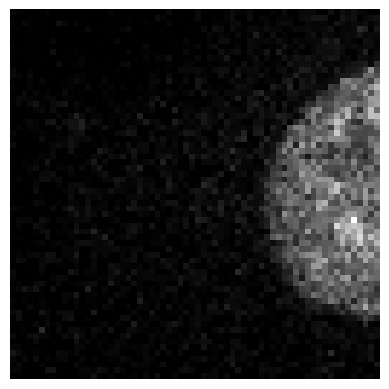

In [ ]:
file_path = './_test/HV110_P0500510000.h5/X/1'

im , _ = hdf5_reader()(file_path)
plot_image(im)


In [ ]:
#| export
def extract_random_patches(data, # numpy array of the input data (n-dimensional).
                           patch_size, # tuple of integers defining the size of the patches in each dimension.
                           num_patches, # number of random patches to extract.
                           ):
    """
    Extracts a specified number of random n-dimensional patches from the input data.
    
    Returns:
    - A list of randomly cropped patches as numpy arrays.
    """
    data_shape = data.shape
    ndim = len(data_shape)
    
    # Ensure patch size fits within the data dimensions
    for dim in range(ndim):
        if patch_size[dim] > data_shape[dim]:
            raise ValueError(f"Patch size {patch_size[dim]} exceeds data dimension {data_shape[dim]} in dimension {dim}")
    
    patches = []
    
    for _ in range(num_patches):
        # Randomly select the starting point for each dimension
        start_coords = [random.randint(0, data_shape[dim] - patch_size[dim]) for dim in range(ndim)]
        
        # Create slices for the selected patch
        patch_slices = tuple(slice(start_coords[dim], start_coords[dim] + patch_size[dim]) for dim in range(ndim))
        
        # Extract the patch and add to the list
        patches.append(data[patch_slices])
    
    return patches


In [ ]:
#| export
def save_patches_random(data_folder,                # Path to the folder containing data files (n-dimensional data).
                        gt_folder,                  # Path to the folder containing ground truth (gt) files (n-dimensional data).
                        output_folder,              # Path to the folder where the HDF5 files will be saved.
                        patch_size,                 # tuple of integers defining the size of the patches.
                        num_patches,                # number of random patches to extract per file.
                        threshold=None,             # If provided, patches with a mean value below this threshold will be discarded.
                        squeeze_input=True,         # If True, squeezes singleton dimensions in the input data.
                        squeeze_patches=False,      # If True, squeezes singleton dimensions in the patches.
                        csv_output=True,            # If True, a CSV file listing all patch paths is created.
                        train_test_split_ratio=0.8, # Ratio of data to split into train and test CSV files (e.g., 0.8 for 80% train).
                        ):
    """
    Loads n-dimensional data from data_folder and gt_folder, generates random patches, and saves them into individual HDF5 files.
    Each HDF5 file will have datasets with the structure X/patch_idx and y/patch_idx.
    
    """
    
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Ensure the folders contain the same number of files
    data_files = sorted([f for f in os.listdir(data_folder) if f.endswith(('.npy', '.npz', '.png', '.tif', '.tiff'))])
    gt_files = sorted([f for f in os.listdir(gt_folder) if f.endswith(('.npy', '.npz', '.png', '.tif', '.tiff'))])
    
    if len(data_files) != len(gt_files):
        raise ValueError("The number of files in data_folder and gt_folder must be the same.")
    
    # Prepare CSV records list
    csv_records = []
    
    # Loop through the files in the folders with progress bar
    for data_file_name, gt_file_name in tqdm(zip(data_files, gt_files), total=len(data_files), desc="Processing files"):
        data_file_path = os.path.join(data_folder, data_file_name)
        gt_file_path = os.path.join(gt_folder, gt_file_name)
        
        # Load the images
        data = np.array(image_reader(data_file_path))
        gt = np.array(image_reader(gt_file_path))  
        
        if squeeze_input:
            data = np.squeeze(data)
            gt = np.squeeze(gt)
                  
        if data.shape != gt.shape:
            raise ValueError(f"Shape mismatch between {data_file_name} and {gt_file_name}")
        
        # Extract random patches from both datasets
        data_patches_nd = extract_random_patches(data, patch_size, num_patches)
        gt_patches_nd = extract_random_patches(gt, patch_size, num_patches)
        
        if squeeze_patches:
            data_patches_nd = np.squeeze(data_patches_nd)
            gt_patches_nd = np.squeeze(gt_patches_nd)
            
        # Create a new HDF5 file for this pair of files
        hdf5_filename = os.path.join(output_folder, f"{os.path.splitext(data_file_name)[0]}_random_patches.h5")
        
        with h5py.File(hdf5_filename, 'w') as hf:
            patch_counter = 0  # Counter to number the valid patches
            
            # Store each patch in a separate dataset with a progress bar for each file
            for data_patch, gt_patch in tqdm(zip(data_patches_nd, gt_patches_nd), 
                                             total=num_patches, 
                                             desc=f"Saving random patches for {data_file_name}", 
                                             leave=False):
                # Calculate the mean of the patch and discard if below threshold (if provided)
                if threshold is not None and np.mean(data_patch) < threshold:
                    continue  # Skip this patch
                
                hf.create_dataset(f'X/{patch_counter}', data=data_patch)
                hf.create_dataset(f'y/{patch_counter}', data=gt_patch)
                
                # Append patch paths to CSV records
                csv_records.append({
                    "path_signal": f"{hdf5_filename}/X/{patch_counter}",
                    "path_target": f"{hdf5_filename}/y/{patch_counter}"
                })
                
                patch_counter += 1  # Increment the patch counter only for valid patches
    
    # Save the paths to a CSV file if csv_output is True
    if csv_output:
        csv_df = pd.DataFrame(csv_records)
        
        if train_test_split_ratio is not None and 0 < train_test_split_ratio < 1:
            # Split data into train and test sets
            train_df, test_df = train_test_split(csv_df, train_size=train_test_split_ratio, random_state=42)
            
            # Save train and test CSVs
            train_csv_path = os.path.join(output_folder, "train_patches.csv")
            test_csv_path = os.path.join(output_folder, "test_patches.csv")
            train_df.to_csv(train_csv_path, index=False)
            test_df.to_csv(test_csv_path, index=False)
            print(f"CSV files saved to: {train_csv_path} and {test_csv_path}")
        
        else:
            # Save a single CSV file
            csv_path = os.path.join(output_folder, "all_patches.csv")
            csv_df.to_csv(csv_path, index=False)
            print(f"CSV file saved to: {csv_path}")


In [ ]:
data_folder = '/home/biagio/Code/Noise2Model/_data/Confocal_BPAE_B/raw/1'
gt_folder = '/home/biagio/Code/Noise2Model/_data/Confocal_BPAE_B/raw/1'
output_folder = './_test2'
patch_size = (64,64)
num_patches= 2
save_patches_random(data_folder, gt_folder, output_folder, patch_size, num_patches)

Processing files: 100%|██████████| 50/50 [00:00<00:00, 57.41it/s]

CSV files saved to: ./_test2/train_patches.csv and ./_test2/test_patches.csv


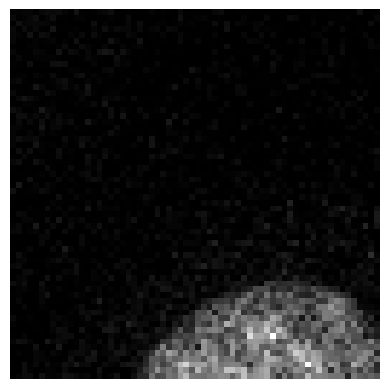

In [ ]:
file_path = './_test2/HV110_P0500510000_random_patches.h5/X/1'

im , _ = hdf5_reader()(file_path)
plot_image(im)

In [ ]:
#| export
def dict2string(d, # The dictionary to convert.
                item_sep="_", # The separator between dictionary items (default is ", ").
                key_value_sep="", # The separator between keys and values (default is ": ").
                pad_zeroes=None, # The minimum width for integer values, padded with zeros. If None, no padding is applied.
                ):
    """
    Transforms a dictionary into a string with customizable separators and optional zero padding for integers.

    Returns the formatted dictionary as a string.
    """
    def format_value(value):
        if isinstance(value, int) and pad_zeroes is not None:
            return f"{value:0{pad_zeroes}d}"
        return str(value)
    
    return item_sep.join(f"{k}{key_value_sep}{format_value(v)}" for k, v in d.items())


In [ ]:
my_dict = {'C': 2, 'Z': 30, 'S': 1}
result = dict2string(my_dict, pad_zeroes=3)
print(result)

C002_Z030_S001


In [ ]:
#| export
def remove_singleton_dims(substack, # The extracted substack data.
                          order, # The dimension order string (e.g., 'CZYX').
                          ):
    """
    Remove dimensions with a size of 1 from both the substack and the order string.

    Returns: \n
        substack (np.array): The substack with singleton dimensions removed.
        new_order (str): The updated dimension order string.
    """
    new_order = ""
    new_shape = []
    
    for i, dim in enumerate(order):
        if substack.shape[i] > 1:  # Keep only dimensions with more than 1 slice
            new_order += dim
            new_shape.append(substack.shape[i])
    
    substack = substack.reshape(new_shape)  # Remove singleton dimensions
    return substack, new_order

In [ ]:
#| export
def extract_substacks(input_file, # Path to the input OME-TIFF file.
                      output_dir=None, # Directory to save the extracted substacks. If a list, the substacks will be saved in the corresponding subdirectories from the list.
                      indices=None,# A dictionary specifying which indices to extract. Keys can include 'C' for channel, 'Z' for z-slice, 'T' for time point, and 'S' for scene. If None, all indices are extracted.
                      split_dimension=None,# Dimension to split substacks along. If provided, separate substacks will be generated for each index in the split_dimension. Must be one of the keys in indices.
                      squeeze_dims=True, # Dimension to squeeze substacks along. 
                      *kwargs):
    """
    Extract substacks from a multidimensional OME-TIFF stack using AICSImageIO.

    """
    # Load the OME-TIFF file
    image = AICSImage(input_file)

    # Extract the base name of the input file (without path and extension)
    base_filename = os.path.splitext(os.path.basename(input_file))[0]   
    # Remove complex extensions like .ome.tiff or .ome.tif
    base_filename = os.path.splitext(base_filename)[0]
    
    # Get dimensions order
    order = image.dims.order

    # Update defaults with user-specified indices
    if indices is None:
        indices = dict()
        
    # Convert any numpy.int types in indices to Python int
    indices = {k: int(v) if isinstance(v, (np.integer, np.int64)) else v for k, v in indices.items()}

    # If split_dimension is provided, create substacks for each index in that dimension
    if split_dimension is not None and split_dimension in indices:
        # Extract the dimension indices from the input data
        split_indices = indices[split_dimension]
        if isinstance(split_indices, int):
            split_indices = [split_indices]  # Ensure it's a list even if a single index is passed

        # Ensure output_dir is a list of directories or convert to list of subfolder names by index
        if output_dir is not None and isinstance(output_dir, list):
            if len(output_dir) != len(split_indices):
                if len(output_dir) == 1:
                    output_dir_list = [os.path.join(output_dir[0], f"{split_dimension}_{i}") for i in split_indices]
                else:
                    raise ValueError(f"The number of subdirectories in output_dir ({len(output_dir)}) does not match the number of substacks ({len(split_indices)}).")
            else:
                output_dir_list = output_dir
        elif output_dir is not None:
            output_dir_list = [output_dir] * len(split_indices)
        else:
            output_dir_list = [None] * len(split_indices)  # No output_dir provided, substack is returned.

        # Loop through indices in the split dimension
        for i, idx in enumerate(split_indices):
            # Adjust the indices dictionary for the current index in split_dimension
            current_indices = indices.copy()
            current_indices[split_dimension] = int(idx) 
            
            # Extract the substack for the current index
            substack = image.get_image_data(order, **current_indices)
            
            # Remove singleton dimensions
            if squeeze_dims:
                substack, new_order = remove_singleton_dims(substack, order)
            else:
                new_order = order

            # Save the substack
            if output_dir is None:
                return substack  # Return the first substack if no output_dir is specified
            
            # Ensure the specific subfolder exists
            os.makedirs(output_dir_list[i], exist_ok=True)
            
            # Construct output filename
            output_filename = f"{base_filename}_substack_{dict2string(current_indices, *kwargs)}.ome.tiff"
            output_path = os.path.join(output_dir_list[i], output_filename)

            # Save the substack
            OmeTiffWriter.save(substack, output_path, dim_order=new_order)

            print(f"Extracted substack saved to: {output_path}")
    
    else:
        # No split_dimension provided, extract the entire substack
        substack = image.get_image_data(order, **indices)
        
        # Remove singleton dimensions
        if squeeze_dims:
            substack, new_order = remove_singleton_dims(substack, order)
        else:
            new_order = order

        if output_dir is None:
            return substack  # Return substack if no output_dir is provided

        # Ensure output directory exists
        os.makedirs(output_dir, exist_ok=True)
        
        # Construct output filename
        output_filename = f"{base_filename}_substack_{dict2string(indices, *kwargs)}.ome.tiff"
        output_path = os.path.join(output_dir, output_filename)

        # Save the substack
        OmeTiffWriter.save(substack, output_path, dim_order=new_order)

        print(f"Extracted substack saved to: {output_path}")


In [ ]:
output_dir = "./_test_folder/"
subdirs = [output_dir + folder for folder in ["channel_0", "channel_1", "channel_2"]]
subdirs

['./_test_folder/channel_0',
 './_test_folder/channel_1',
 './_test_folder/channel_2']

In [ ]:
[os.path.join([output_dir][0], f"{subdirs[0]}_{ii}") for ii in range(2)]

['./_test_folder/./_test_folder/channel_0_0',
 './_test_folder/./_test_folder/channel_0_1']

In [ ]:
filename = '../_data/aics/2cad3afd_3500001004_100X_20170623_5-Scene-6-P29-F05.ome.tiff'

# This extracts a single substack for channel 0, z-slice 5, and time point 0.
extract_substacks(filename, output_dir=output_dir, indices={"C": 0, "Z": range(35), "T": 0})


Extracted substack saved to: ./_test_folder/2cad3afd_3500001004_100X_20170623_5-Scene-6-P29-F05_substack_C0_Zrange(0, 35)_T0.ome.tiff


In [ ]:
# This extracts substacks for each channel (`C`) and saves them in separate subfolders named "C_0", "C_1", "C_2", etc.
extract_substacks(filename, output_dir=[output_dir], indices={"C": [0, 1, 2], "Z": 5, "T": 0}, split_dimension="C")


Extracted substack saved to: ./_test_folder/C_0/2cad3afd_3500001004_100X_20170623_5-Scene-6-P29-F05_substack_C0_Z5_T0.ome.tiff
Extracted substack saved to: ./_test_folder/C_1/2cad3afd_3500001004_100X_20170623_5-Scene-6-P29-F05_substack_C1_Z5_T0.ome.tiff
Extracted substack saved to: ./_test_folder/C_2/2cad3afd_3500001004_100X_20170623_5-Scene-6-P29-F05_substack_C2_Z5_T0.ome.tiff


In [ ]:

# This extracts substacks for each channel and saves them in directories "channel_0", "channel_1", and "channel_2".
extract_substacks(filename, output_dir=subdirs, indices={"C": [0, 1, 2], "Z": 5}, split_dimension="C")


Extracted substack saved to: ./_test_folder/channel_0/2cad3afd_3500001004_100X_20170623_5-Scene-6-P29-F05_substack_C0_Z5.ome.tiff
Extracted substack saved to: ./_test_folder/channel_1/2cad3afd_3500001004_100X_20170623_5-Scene-6-P29-F05_substack_C1_Z5.ome.tiff
Extracted substack saved to: ./_test_folder/channel_2/2cad3afd_3500001004_100X_20170623_5-Scene-6-P29-F05_substack_C2_Z5.ome.tiff


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()